In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


# Data Info Check

In [1]:
# data path
data_path_01 = '/content/drive/MyDrive/A Colorectal Tumor Organoid Library Demonstrates Progressive Loss of Niche Factor Requirements during Tumorigenesis_supple.xlsx'
data_path_02 = '/content/drive/MyDrive/more_columns-Table 1.csv'
data_path_03 = '/content/drive/MyDrive/label_data-Table 1.csv'

# library
import warnings; warnings.filterwarnings('ignore')
import pandas as pd
import openpyxl
import re

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

> Loading excel data

In [2]:
# loading excel data
wb1 = openpyxl.load_workbook(data_path_01)
# wb2 = openpyxl.load_workbook(data_path_02)

> Focused on CRC patients data

In [3]:
# loading data from the first excel sheet
patient_list = wb1.sheetnames
# focued on CRC
CRC_list = [patient for patient in patient_list if patient.startswith('CRC')]
print(CRC_list)

['CRC1a', 'CRC1b', 'CRC2', 'CRC3', 'CRC4', 'CRC5', 'CRC6', 'CRC7', 'CRC8', 'CRC9', 'CRC10', 'CRC11', 'CRC12', 'CRC13', 'CRC14', 'CRC15', 'CRC16', 'CRC17a', 'CRC17b', 'CRC18', 'CRC19', 'CRC20', 'CRC21', 'CRC22', 'CRC23a', 'CRC23b', 'CRC23c', 'CRC24a', 'CRC24b', 'CRC24c', 'CRC25a', 'CRC25b', 'CRC25c', 'CRC26a', 'CRC26b', 'CRC27', 'CRC28', 'CRC29', 'CRC30', 'CRC31']


> Functions

In [4]:
# function for concating CRC patient dataframes
from tqdm.notebook import tqdm

def concat_dataframes(patient_list: list):
    patient_df_list = []
    for patient in tqdm(patient_list):
        patient_df = pd.read_excel(data_path_01, sheet_name=patient, header=2)
        patient_df['patient_unique_id'] = patient
        patient_df_list.append(patient_df)

    return pd.concat(patient_df_list)

CRC_final_df = concat_dataframes(CRC_list)

  0%|          | 0/40 [00:00<?, ?it/s]

> Independent variables for use

In [64]:
# colums for use
crc_column_list = ['APC', 'CTNNB1','TCF7L2','FAM123B','SOX9','RNF43',
                       'KRAS','NRAS','BRAF','PIK3CA','TGFR2','ACVR2A','SMAD1',
                       'SMAD3','SMAD4','TP53','FBXW7','MLH1']
len(crc_column_list)

18

> Creating new dataframe to run model

In [6]:
  tmp_crc_dict = {'patient_unique_id' : None, 'APC' : 0, 'CTNNB1' : 0,'TCF7L2' : 0,'FAM123B' : 0,'SOX9' : 0,'RNF43' : 0,
                    'KRAS' : 0, 'NRAS' : 0, 'BRAF' : 0,'PIK3CA' : 0, 'TGFR2' : 0, 'ACVR2A' : 0, 'SMAD1' : 0,
                    'SMAD3' : 0, 'SMAD4' : 0, 'TP53' : 0, 'FBXW7' : 0, 'MLH1' : 0
                    }

In [7]:
crc_df_list = []
for idx, patient in tqdm(enumerate(CRC_list)):
    CRC_tmp_df = CRC_final_df[CRC_final_df['patient_unique_id'] == patient] # spliting dataframes by differenct CRC patient
    common_gene_list = list(set(CRC_tmp_df['Gene_symbole'].unique().tolist()) & set(crc_column_list)) # finding common columns between each CRC patient's Gene_symbole and columns for use
    # dictionary to make CRC dataframes for modeling
    tmp_crc_dict = dict()
    for col in crc_column_list:
        if col in common_gene_list:
            tmp_crc_dict[col] = 1 # if column is in the common column list, then it is 1
        else:
            tmp_crc_dict[col] = 0 # if not, 0
    # tmp_crc_dict['patient'] = patient
    crc_df_list.append(pd.DataFrame(tmp_crc_dict, index=[patient])) # use patient id as index
new_df = pd.concat(crc_df_list) # creating new_df

0it [00:00, ?it/s]

In [8]:
final_df = new_df.reset_index()
final_df.columns = ['patient_id'] + crc_column_list

In [ ]:
final_df # final_df before merging more columns and label data

> Adding more independent variables and labels

In [10]:
# more indepedent variables
# preprocessing
more_columns_df = pd.read_csv(data_path_02, header=1)
more_columns_df = more_columns_df.iloc[:, :--5]
more_columns_df.columns = ['patient_id', 'gender', 'age', 'microsatelite', 'stage'] # setting column names

In [11]:
# only CRC data
more_columns_df = more_columns_df[15:].reset_index(drop=True)
more_columns_df.head(2)

,patient_id,gender,age,microsatelite,stage
0,CRC1a,0,84.0,0.0,1.0
1,CRC1b,0,84.0,0.0,1.0


In [12]:
# remove empty spaces
more_columns_df['patient_id'] = more_columns_df['patient_id'].apply(lambda x: x.replace('\xa0', '').replace(' ', ''))

In [13]:
# label data
label_df = pd.read_csv(data_path_03, header=1)
label_df.columns = ['patient_id', 'Wnt/Rspondin', 'EGF', 'p38i', 'Noggin', 'TGFbi', 'Normoxia']

In [14]:
# only CRC data
label_df = label_df[15:].reset_index(drop=True)
label_df.head(2)

,patient_id,Wnt/Rspondin,EGF,p38i,Noggin,TGFbi,Normoxia
0,CRC1a,0,0,0,1,1,0
1,CRC1b,0,0,0,1,1,0


In [15]:
# remove empty spaces
label_df['patient_id'] = label_df['patient_id'].apply(lambda x: x.replace('\xa0', '').replace(' ', ''))

> Merging more columns and label data

In [16]:
final_more_columns_df = pd.merge(final_df, more_columns_df, on='patient_id')
crc_df = pd.merge(final_more_columns_df, label_df, on='patient_id')
crc_df.head(4) # processing dataframes dones

,patient_id,APC,CTNNB1,TCF7L2,FAM123B,SOX9,RNF43,KRAS,NRAS,BRAF,...,gender,age,microsatelite,stage,Wnt/Rspondin,EGF,p38i,Noggin,TGFbi,Normoxia
0,CRC1a,1,0,0,0,0,0,0,0,1,...,0,84.0,0.0,1.0,0,0,0,1,1,0
1,CRC1b,1,1,0,0,0,0,1,0,0,...,0,84.0,0.0,1.0,0,0,0,1,1,0
2,CRC2,1,0,1,0,0,0,1,0,0,...,0,69.0,0.0,1.0,0,1,0,1,1,0
3,CRC3,1,0,0,0,0,0,1,1,0,...,1,80.0,0.0,1.0,0,1,1,1,0,0


In [17]:
# save dataframe for further use
crc_df.to_csv('/content/drive/MyDrive/CRC_df.csv', index=False)

# Data EDA

> Independent variables

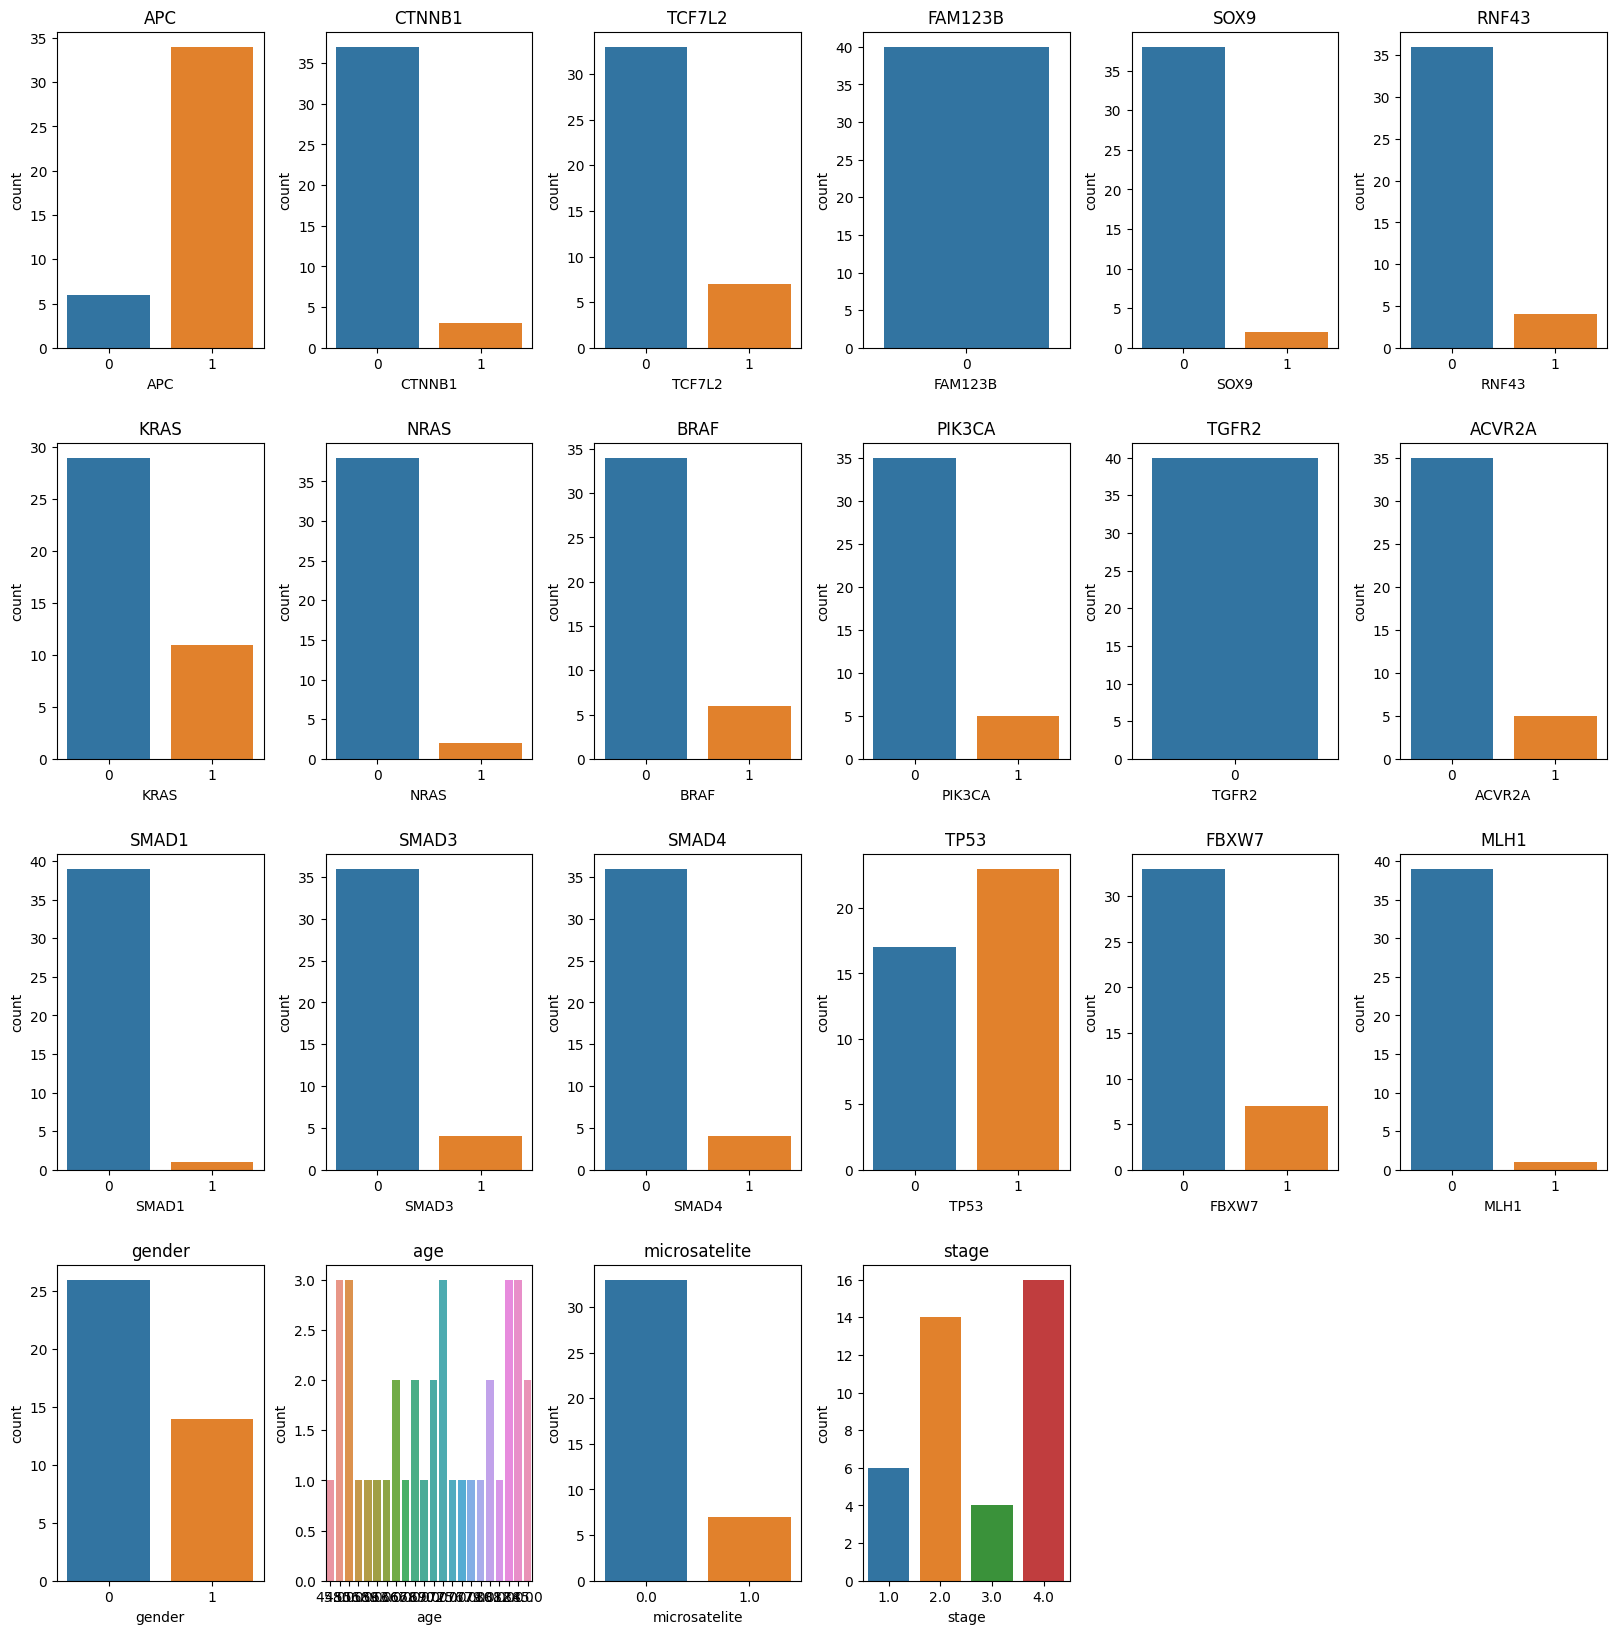

In [18]:
plt.figure(figsize=(20,20))
x=1
plt.subplots_adjust(top=.99, bottom=.01, hspace=.3, wspace=.3)
for column_name in crc_df.iloc[:, 1:-6].columns.tolist():
    plt.subplot(5,6,x)
    x=x+1
    # df[column_name].value_counts().sort_index().plot(kind='bar')
    sns.countplot(data=crc_df, x=column_name)
    plt.title(column_name)
plt.show()

# FAM123B, TGFR2는 쓸 수 없는 컬럼

> Dependent variables

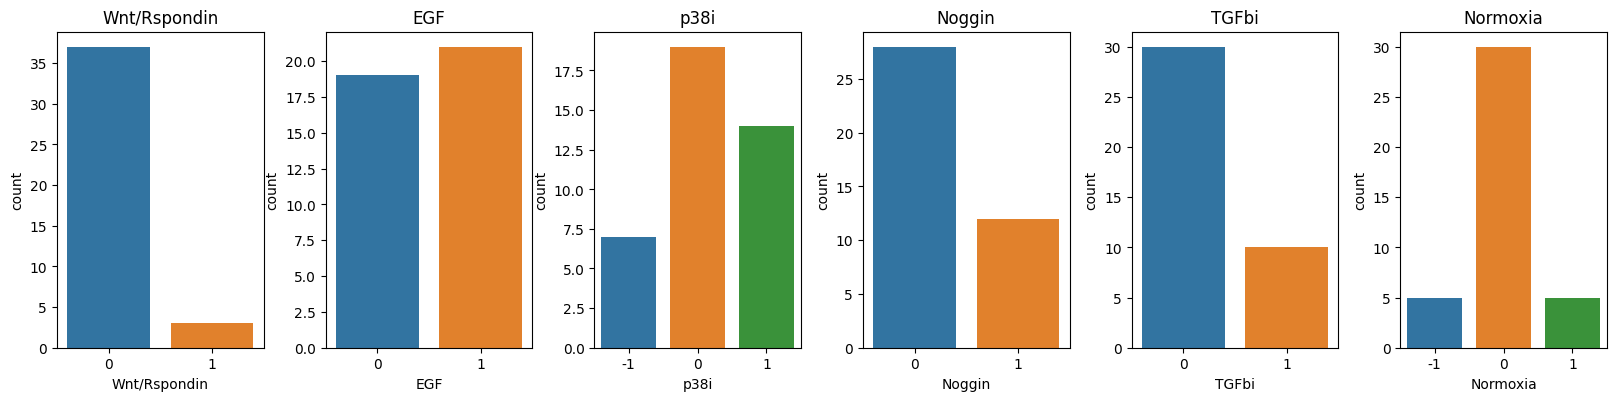

In [19]:
plt.figure(figsize=(20,20))
x=1
plt.subplots_adjust(top=.99, bottom=.01, hspace=.3, wspace=.3)
for column_name in crc_df.iloc[:, -6:].columns.tolist():
    plt.subplot(5,6,x)
    x=x+1
    # df[column_name].value_counts().sort_index().plot(kind='bar')
    sns.countplot(data=crc_df, x=column_name)
    plt.title(column_name)
plt.show()

In [20]:
# labels are multi-class 01
crc_df['p38i'].value_counts()

 0    19
 1    14
-1     7
Name: p38i, dtype: int64

In [21]:
# labels are multi-class 02
crc_df['Normoxia'].value_counts()

 0    30
-1     5
 1     5
Name: Normoxia, dtype: int64

> Filling null values --> Age

In [22]:
# if want the df that have null values from age, use this dataframe
crc_df = pd.read_csv('/content/drive/MyDrive/CRC_df.csv')

<Axes: xlabel='age', ylabel='Count'>

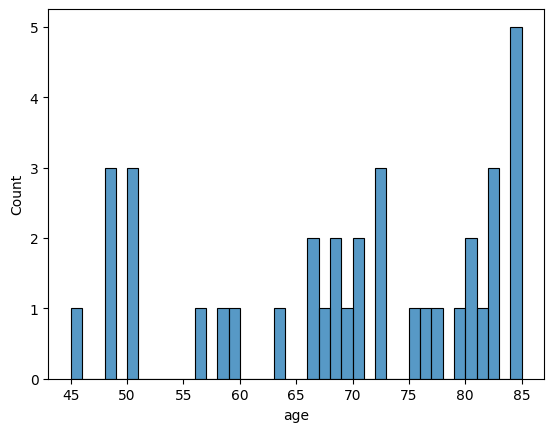

In [23]:
sns.histplot(data=crc_df, x='age', bins=40)

In [24]:
# use k-nn algorithm to fill null values
import numpy as np
from sklearn.impute import KNNImputer

# Sample dataset with missing values
data = crc_df.iloc[:, 1:-6]

# Initialize the KNNImputer with the number of neighbors (k)
knn_imputer = KNNImputer(n_neighbors=2)

# Perform imputation
imputed_data = knn_imputer.fit_transform(data)

In [ ]:
new_df = pd.DataFrame(imputed_data)
new_df.columns = crc_df.columns[1:-6]
new_df # filled null values

In [26]:
# add label to new_df
new_df = pd.concat([new_df, crc_df.iloc[:, -6:]], axis=1)

# Modeling

    <Logistic Regression>

    <RandomForest>

    <CatBoost> -> need more data than now

In [27]:
# libraries
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
import numpy as np

> Spliting train and test data

In [257]:
# independent variables
X = new_df.iloc[:, :-6]

# dependent variables
y1 = new_df.iloc[:, -6] # Wnt/Rrpondin
y2 = new_df.iloc[:, -5] # EGF
y3 = new_df.iloc[:, -4] # p38i
y4 = new_df.iloc[:, -3] # Noggin
y5 = new_df.iloc[:, -2] # TFGbi
y6 = new_df.iloc[:, -1] # Normoxia

In [29]:
x_train, x_test, y_train, y_test = train_test_split(X, y1,
                                                    test_size=.2, # test_size --> .2? try different ratio
                                                    stratify=y1)

> sampling data

In [143]:
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

# SMOTE
sm = SMOTE(random_state=5, k_neighbors=1)
X_sm_sampling, y_sm_sampling = sm.fit_resample(x_train, y_train)

# SMOTEENN
# combined_sm = SMOTEENN(random_state=5,)
# X_csm_sampling, y_csm_sampling = combined_sm.fit_resample(x_train, y_train)

In [31]:
y_sm_sampling.value_counts()

0    30
1    30
Name: Wnt/Rspondin, dtype: int64

> Logistic Regression

In [250]:
# modeling

x_train, x_test, y_train, y_test = train_test_split(X, y5,
                                                    test_size=.2, # test_size --> .2? try different ratio
                                                    stratify=y5,
                                                    random_state=5)

lr_clf = LogisticRegressionCV(cv=5,
                     penalty='elasticnet',
                     solver='saga',
                     Cs=np.power(10, np.arange(-3,1,dtype=float)),
                     l1_ratios=np.linspace(0,1,num=6, dtype=float),
                     max_iter=100,
                     random_state=5)
lr_clf.fit(x_train, y_train)

# prediction
y_pred_test = lr_clf.predict(x_test)
y_pred_train = lr_clf.predict(x_train)
y_pred_proba_test = lr_clf.predict_proba(x_test)[:,1]
y_pred_proba_train = lr_clf.predict_proba(x_train)[:,1]

f1_score_test = f1_score(y_test, y_pred_test, average='macro')
f1_score_train = f1_score(y_train, y_pred_train, average='macro')
roc_auc_score_test = roc_auc_score(y_test, y_pred_proba_test)
roc_auc_score_train = roc_auc_score(y_train, y_pred_proba_train)
print('roc_auc (train) : ', roc_auc_score_train)
print('roc_auc (test) : ', roc_auc_score_test)
print('f1_score (test) : ', f1_score_test)
print('f2_score (train) : ', f1_score_train)

coef_df = pd.DataFrame(columns=lr_clf.feature_names_in_, data=lr_clf.coef_).T
coef_df.columns = ['coeffcients']
coef_df = pd.DataFrame(coef_df['coeffcients'].sort_values(key=lambda x: np.abs(x))[::-1])

roc_auc (train) :  0.4322916666666667
roc_auc (test) :  0.25
f1_score (test) :  0.42857142857142855
f2_score (train) :  0.42857142857142855


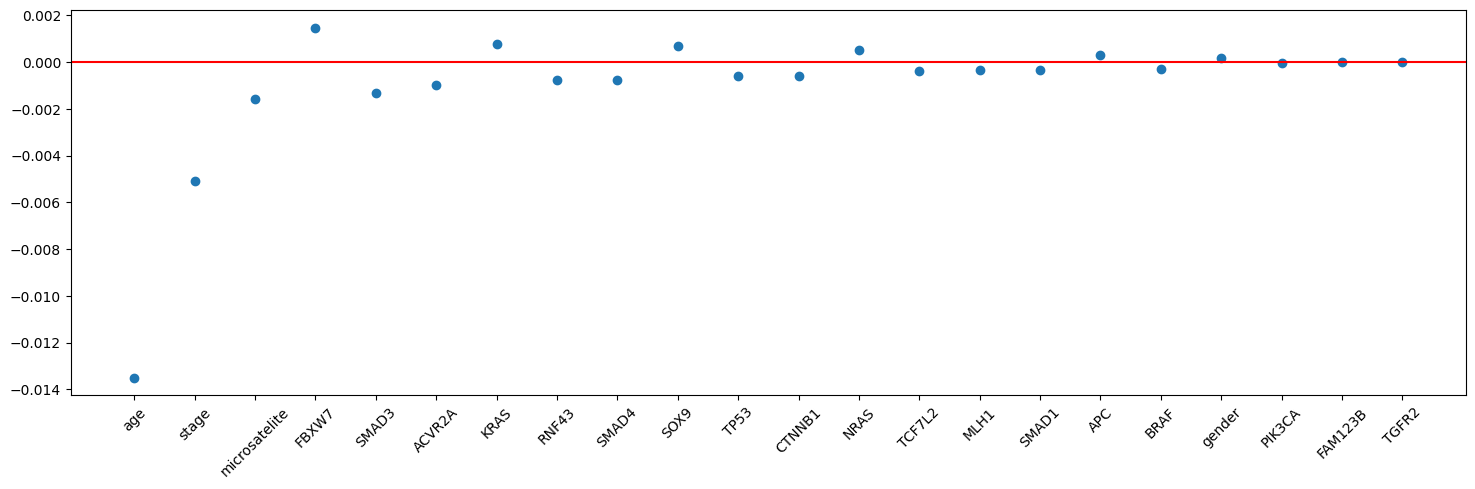

In [251]:
plt.figure(figsize=(18,5))
plt.scatter(y=coef_df['coeffcients'], x=coef_df.index)
plt.axhline(y = 0, color = 'r', linestyle = '-')
plt.xticks(rotation=45)
plt.show()

In [255]:
# modeling with over-sampled data
del lr_clf
lr_clf = LogisticRegressionCV(cv=5,
                     penalty='elasticnet',
                     solver='saga',
                     Cs=np.power(10, np.arange(-3,1,dtype=float)),
                     l1_ratios=np.linspace(0,1,num=6, dtype=float),
                     max_iter=200,
                     random_state=5)
lr_clf.fit(X_sm_sampling, y_sm_sampling)

# prediction
y_pred_test = lr_clf.predict(x_test)
y_pred_train = lr_clf.predict(x_train)
y_pred_proba_test = lr_clf.predict_proba(x_test)[:,1]
y_pred_proba_train = lr_clf.predict_proba(x_train)[:,1]

f1_score_test = f1_score(y_test, y_pred_test, average='macro')
f1_score_train = f1_score(y_train, y_pred_train, average='macro')
roc_auc_score_test = roc_auc_score(y_test, y_pred_proba_test)
roc_auc_score_train = roc_auc_score(y_train, y_pred_proba_train)
print('roc_auc (train) : ', roc_auc_score_train)
print('roc_auc (test) : ', roc_auc_score_test)
print('f1_score (train) : ', f1_score_train)
print('f1_score (test) : ', f1_score_test)

coef_df = pd.DataFrame(columns=lr_clf.feature_names_in_, data=lr_clf.coef_).T
coef_df.columns = ['coeffcients']
coef_df = pd.DataFrame(coef_df['coeffcients'].sort_values(key=lambda x: np.abs(x))[::-1])

roc_auc (train) :  0.7239583333333333
roc_auc (test) :  1.0
f1_score (train) :  0.5
f1_score (test) :  0.7333333333333334


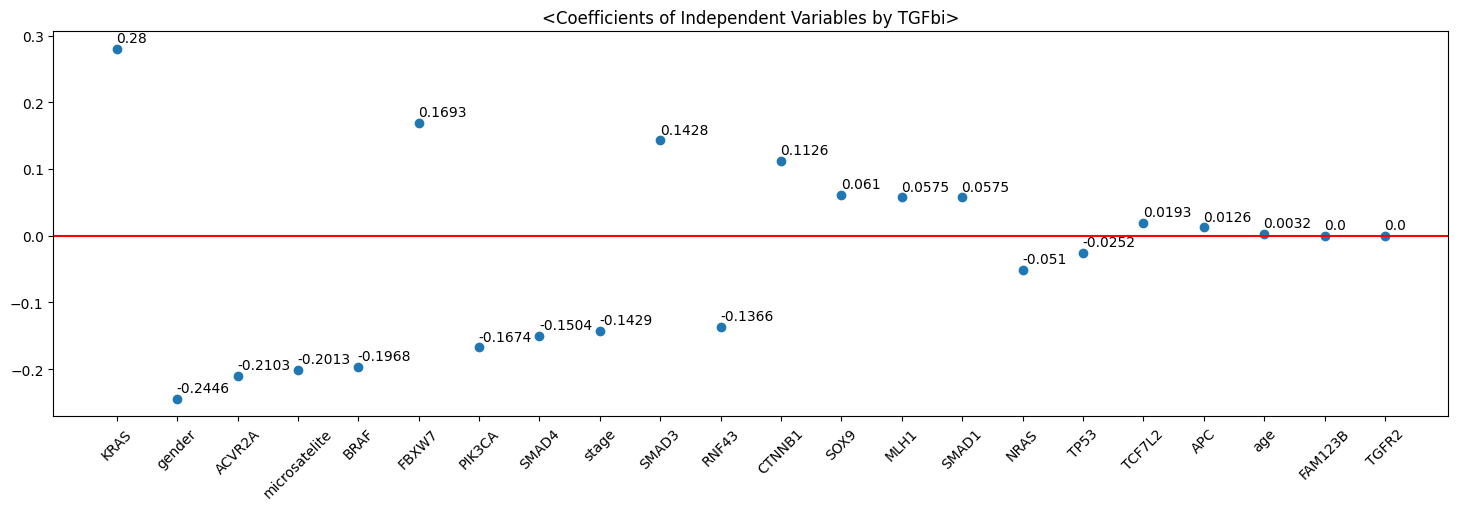

In [256]:
plt.figure(figsize=(18,5))
plt.scatter(y=coef_df['coeffcients'], x=coef_df.index)
plt.axhline(y = 0, color = 'r', linestyle = '-')
for idx, coef in enumerate(coef_df['coeffcients']):
    plt.annotate(round(coef,4), xy=(idx-.01, coef+.01))
plt.xticks(rotation=45)
plt.title('<Coefficients of Independent Variables by {}>'.format('TGFbi'))
plt.show()

> RandomForestClassifier

In [38]:
rf_clf = RandomForestClassifier(max_depth=2,n_estimators=100, n_jobs=-1, criterion='gini',
                                class_weight='balanced', random_state=5 )

rf_clf.fit(x_train, y_train)

y_pred = rf_clf.predict(x_test)
f1_score(y_test, y_pred, average='macro')

1.0

# Results from RandomForest

In [39]:
# function for plotting feature importance (low-level)
def from_modeling_to_plotting(X, y):
    # spliting data
    x_train, x_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=.2, # test_size --> .2? try different ratio
                                                    stratify=y,
                                                        random_state=5)

    # modeling
    rf_clf = RandomForestClassifier(max_depth=2,
                                   n_estimators=100,
                                   n_jobs=-1,
                                   criterion='gini',
                                   class_weight='balanced',
                                    random_state=5
                                    )
    rf_clf.fit(x_train, y_train)
    y_pred = rf_clf.predict(x_test)
    y_pred_proba = rf_clf.predict_proba(x_test)[:, -1]
    print('f1_score --> ', f1_score(y_test, y_pred, average='macro'))
    if y_test.nunique() == 2:
        print('roc_auc_score --> ', roc_auc_score(y_test, y_pred_proba))

    # plotting
    fi_index = np.argsort(rf_clf.feature_importances_)[::-1]
    feature_importance_scores = np.sort(rf_clf.feature_importances_)[::-1]
    feature_importance_columns = new_df.columns[fi_index]


    plt.figure(figsize=(20,5))
    plt.scatter(y=feature_importance_scores, x=feature_importance_columns)
    # plt.title(y)
    plt.show()

    return

def from_modeling_to_plotting_with_over_sampling(X, y):
    # spliting data
    x_train, x_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=.2, # test_size --> .2? try different ratio
                                                    stratify=y,
                                                    random_state=5)
    sm = SMOTE(random_state=5, k_neighbors=1)
    X_sm_sampling, y_sm_sampling = sm.fit_resample(x_train, y_train)

    # modeling
    rf_clf = RandomForestClassifier(max_depth=2,
                                   n_estimators=100,
                                   n_jobs=-1,
                                   criterion='gini',
                                   class_weight='balanced',
                                    random_state=5
                                    )
    rf_clf.fit(X_sm_sampling, y_sm_sampling)
    y_pred = rf_clf.predict(x_test)
    print('f1_score --> ', f1_score(y_test, y_pred, average='macro'))
    y_pred_proba = rf_clf.predict_proba(x_test)[:, -1]
    if y_test.nunique() == 2:
        print('roc_auc_score --> ', roc_auc_score(y_test, y_pred_proba))

    # plotting
    fi_index = np.argsort(rf_clf.feature_importances_)[::-1]
    feature_importance_scores = np.sort(rf_clf.feature_importances_)[::-1]
    feature_importance_columns = new_df.columns[fi_index]


    plt.figure(figsize=(20,5))
    plt.scatter(y=feature_importance_scores, x=feature_importance_columns)
    # plt.title(y)
    plt.show()

    return



> Wnt/Rrpondin

f1_score -->  0.4666666666666667
roc_auc_score -->  0.5714285714285714


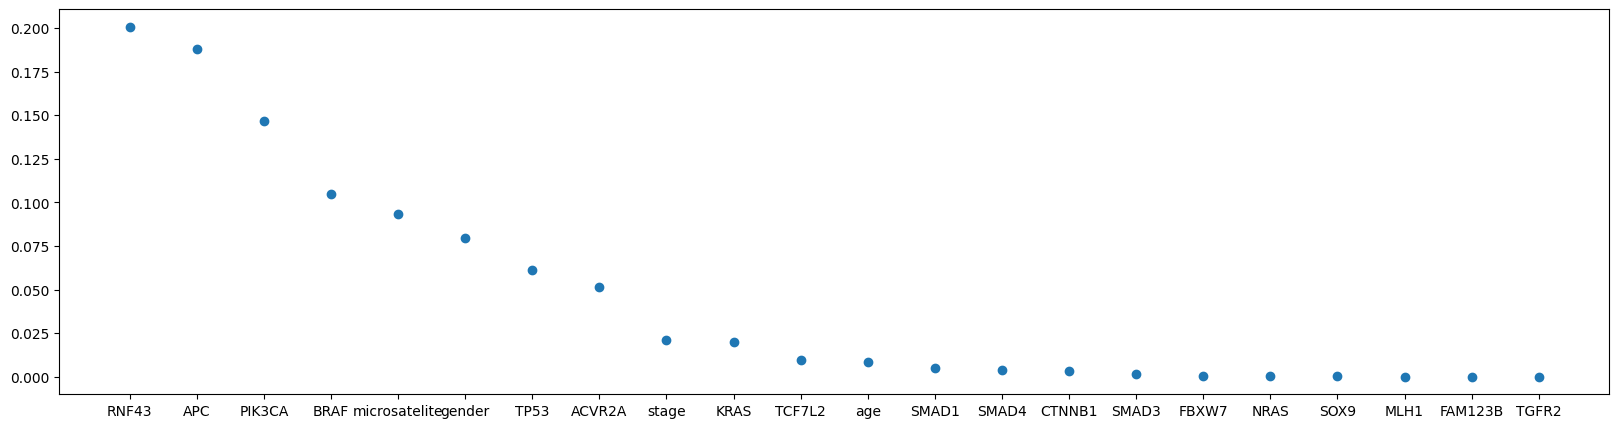

In [40]:
from_modeling_to_plotting(X, y1)

> EGF

f1_score -->  0.5636363636363637
roc_auc_score -->  0.875


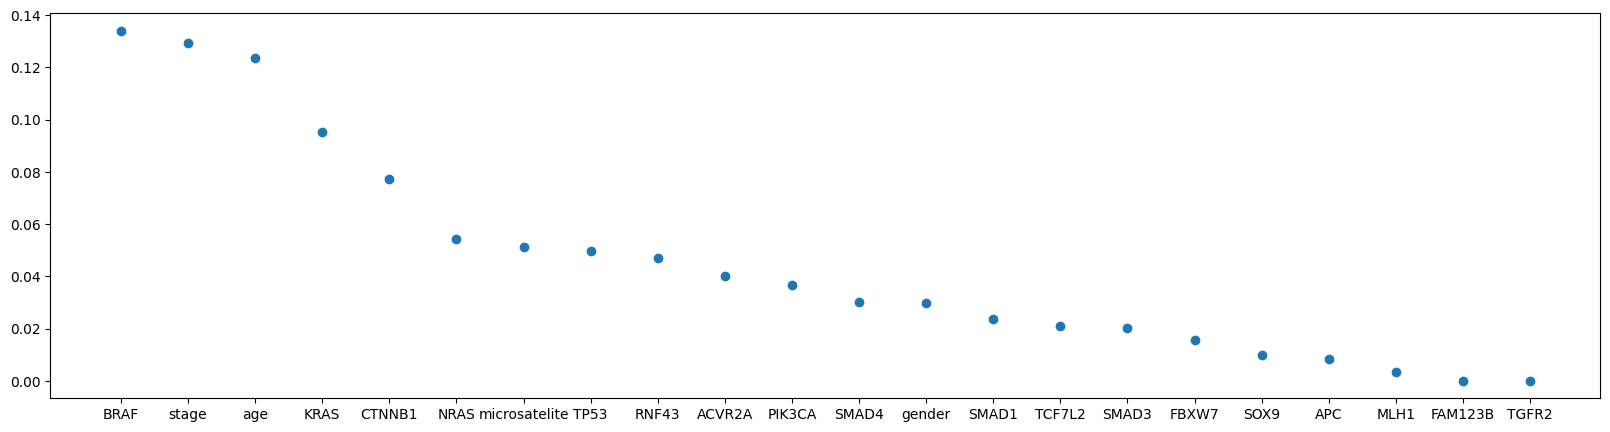

In [41]:
from_modeling_to_plotting(X, y2)

> p38i

f1_score -->  0.7142857142857144


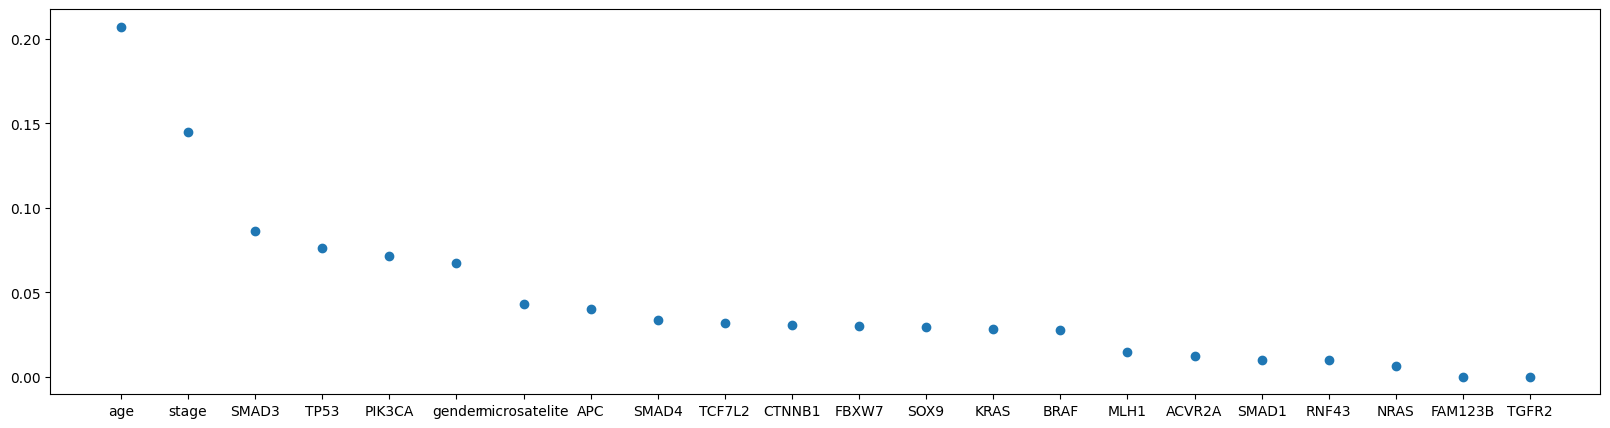

In [42]:
# p38i --> multi-class problem
from_modeling_to_plotting(X, y3)

> Noggin

f1_score -->  0.7948717948717948
roc_auc_score -->  0.5


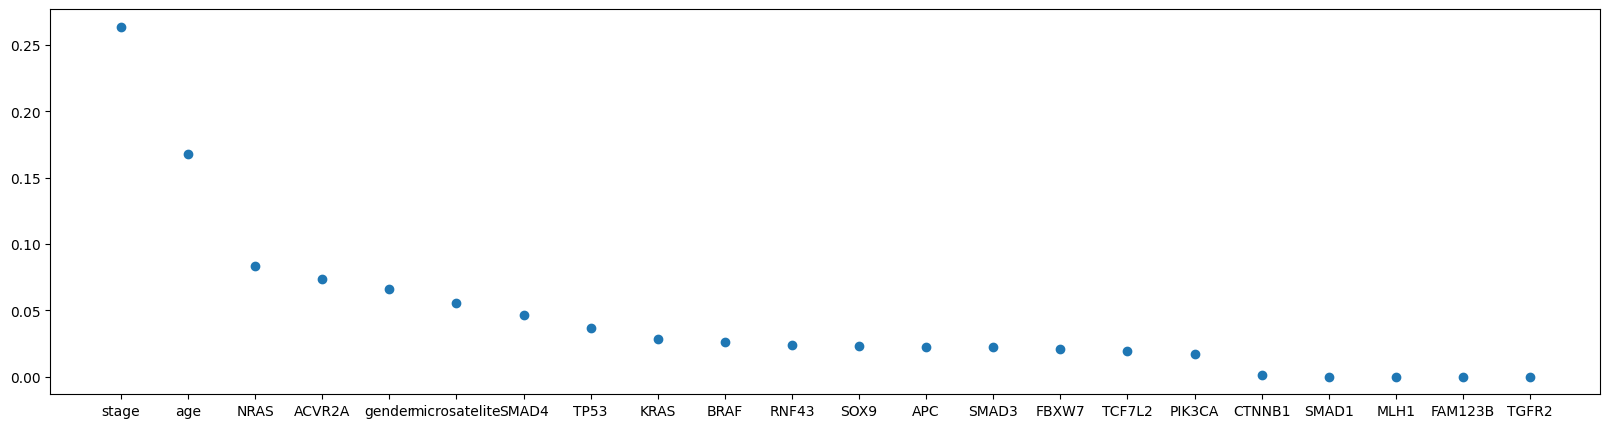

In [43]:
from_modeling_to_plotting(X, y4)

> TGFbi

    condition
    APC
    APC + TP53
    APC + KRAS
    APC + TP53 + KRAS
    at this condition, score of all labels

    각 경우에 대한 점수 (0 or 1), 가 궁금함.

f1_score -->  0.8545454545454545
roc_auc_score -->  0.9166666666666667


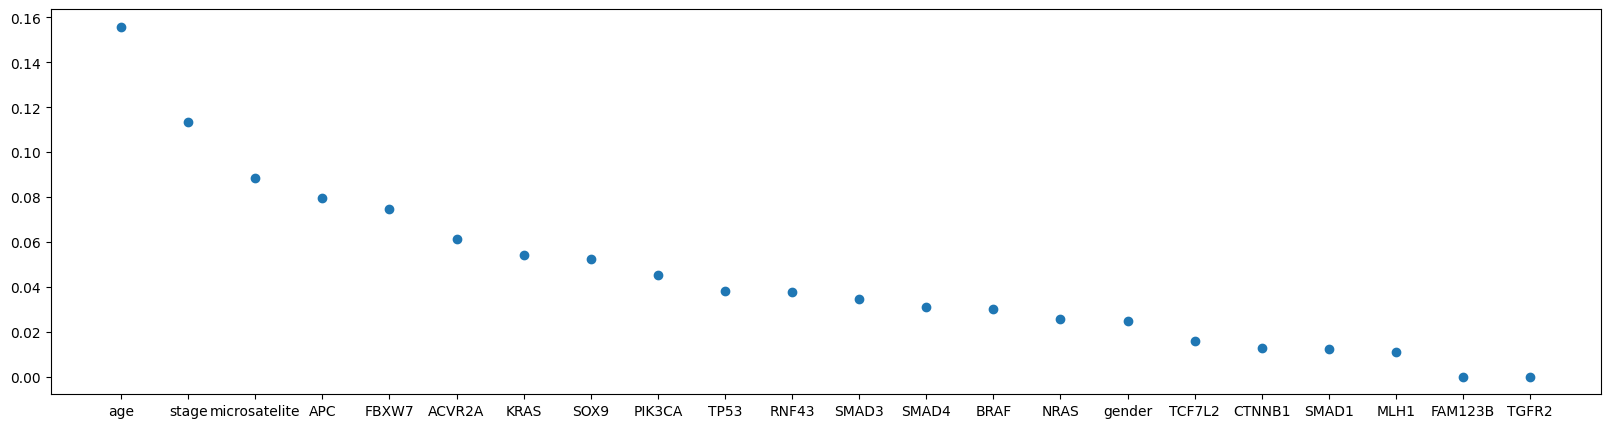

In [44]:
from_modeling_to_plotting(X, y5)

f1_score -->  0.6666666666666667
roc_auc_score -->  0.9166666666666667


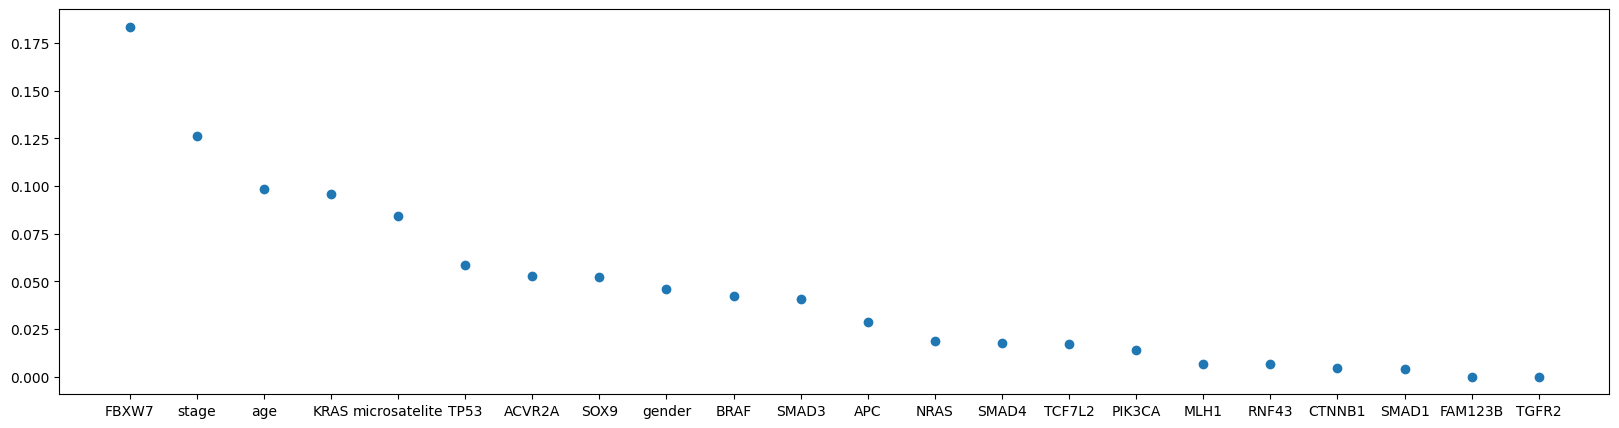

In [45]:
# with over-sampling
from_modeling_to_plotting_with_over_sampling(X, y5)

> Normoxia

f1_score -->  1.0


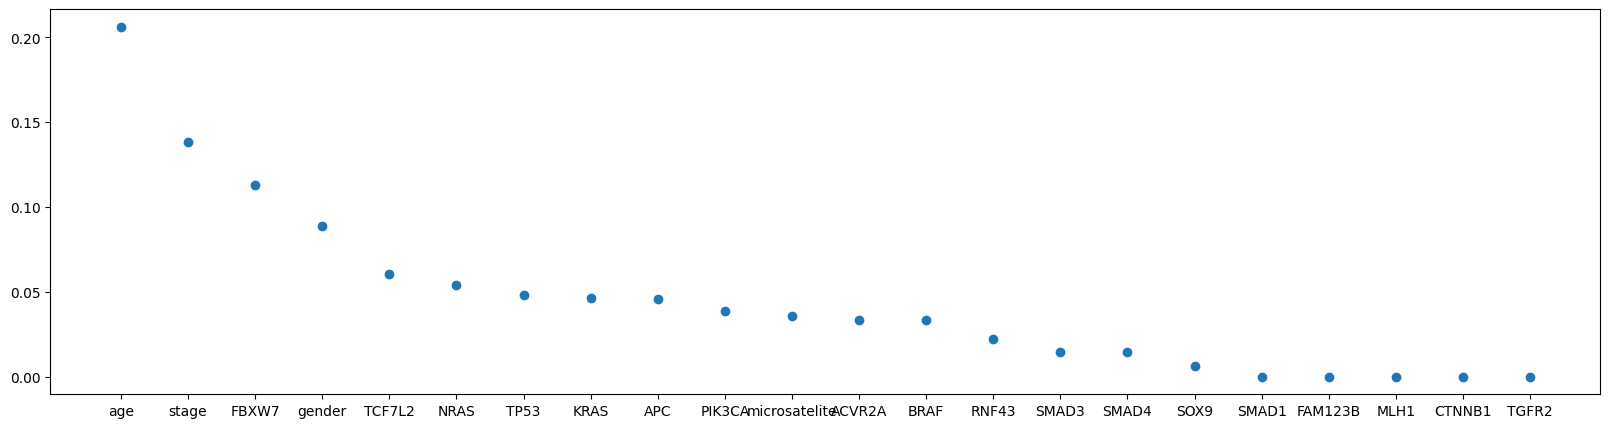

In [47]:
# Normoixa --> multi-class problem
from_modeling_to_plotting(X, y6)

# Report

In [48]:
!pip install -q shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 7.1 MB/s eta 0:00:00


> function revision

In [283]:
import shap

# function without stratify
def from_modeling_to_plotting_without_stratify(X, y):
    # spliting data
    Y = y
    X = X

    idx = list(range(X.shape[0]))
    train_idx, valid_idx = train_test_split(idx, test_size=.3, random_state=5)

    # modeling
    rf_clf = RandomForestClassifier(max_depth=2,
                                    n_estimators=100,
                                    n_jobs=-1,
                                    criterion='gini',
                                    class_weight='balanced',
                                    random_state=5
                                    )
    rf_clf.fit(X.iloc[train_idx], Y.iloc[train_idx])
    y_pred = rf_clf.predict(X.iloc[valid_idx])
    y_pred_proba = rf_clf.predict_proba(X.iloc[valid_idx])[:, -1]
    print('f1_score --> ', f1_score(Y.iloc[valid_idx], y_pred, average='macro'))
    if Y.iloc[valid_idx].nunique() == 2:
        print('roc_auc_score --> ', roc_auc_score(Y.loc[valid_idx], y_pred_proba))

    # plotting
    fi_index = np.argsort(rf_clf.feature_importances_)[::-1]
    feature_importance_scores = np.sort(rf_clf.feature_importances_)[::-1]
    feature_importance_columns = new_df.columns[fi_index]


    plt.figure(figsize=(20,5))
    plt.scatter(y=feature_importance_scores, x=feature_importance_columns)
    # plt.title(y)
    plt.show()

    return

# function with stratify
def from_modeling_to_plotting_with_stratify(X, y):
    # spliting data
    x_train, x_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=.3, # test_size --> .2? try different ratio
                                                    stratify=y,
                                                        random_state=5)

    # modeling
    rf_clf = RandomForestClassifier(max_depth=2,
                                   n_estimators=100,
                                   n_jobs=-1,
                                   criterion='gini',
                                   class_weight='balanced',
                                    random_state=5
                                    )
    rf_clf.fit(x_train, y_train)
    y_pred = rf_clf.predict(x_test)
    y_pred_proba = rf_clf.predict_proba(x_test)[:, -1]
    print('f1_score (정밀도 & 재현율 조화 평균값) --> ', round(f1_score(y_test, y_pred, average='macro'), 4))
    if y_test.nunique() == 2:
        print('roc_auc_score (모델 예측의 정확도) --> ', round(roc_auc_score(y_test, y_pred_proba), 4))

    # plotting
    fi_index = np.argsort(rf_clf.feature_importances_)[::-1]
    feature_importance_scores = rf_clf.feature_importances_[fi_index]
    feature_importance_columns = new_df.columns[fi_index]

    # plotting feature importance plot
    plt.figure(figsize=(20,5))
    # plt.subplots_adjust(wspace=20)
    plt.subplot(121)
    sns.barplot(x=feature_importance_scores, y=feature_importance_columns,
                palette='Blues_r',
                )
    plt.title('<Feature Importance from RF model>', fontsize=15)

    plt.subplot(122)
    plt.annotate(text='<Feature Importance from SHAP>', xy=(.01, 19.6), fontsize=15)
    # plotting feature importance plot from shap
    shap.initjs()

    explainer = shap.TreeExplainer(rf_clf)
    shap_values = explainer.shap_values(x_test)
    shap.summary_plot(shap_values, x_test, plot_size=[15,5])
    plt.show()

    return

> Wnt/Rspondin

f1_score (정밀도 & 재현율 조화 평균값) -->  0.4783
roc_auc_score (모델 예측의 정확도) -->  0.6364


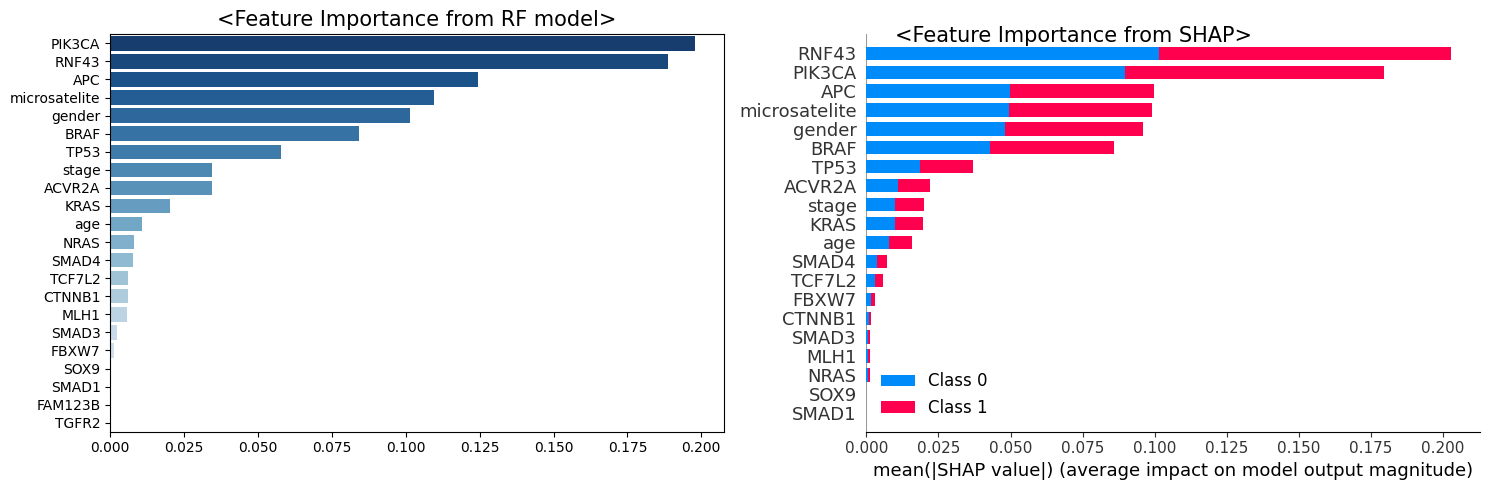

In [284]:
from_modeling_to_plotting_with_stratify(X, y1)

> EGF

f1_score (정밀도 & 재현율 조화 평균값) -->  0.4958
roc_auc_score (모델 예측의 정확도) -->  0.8194


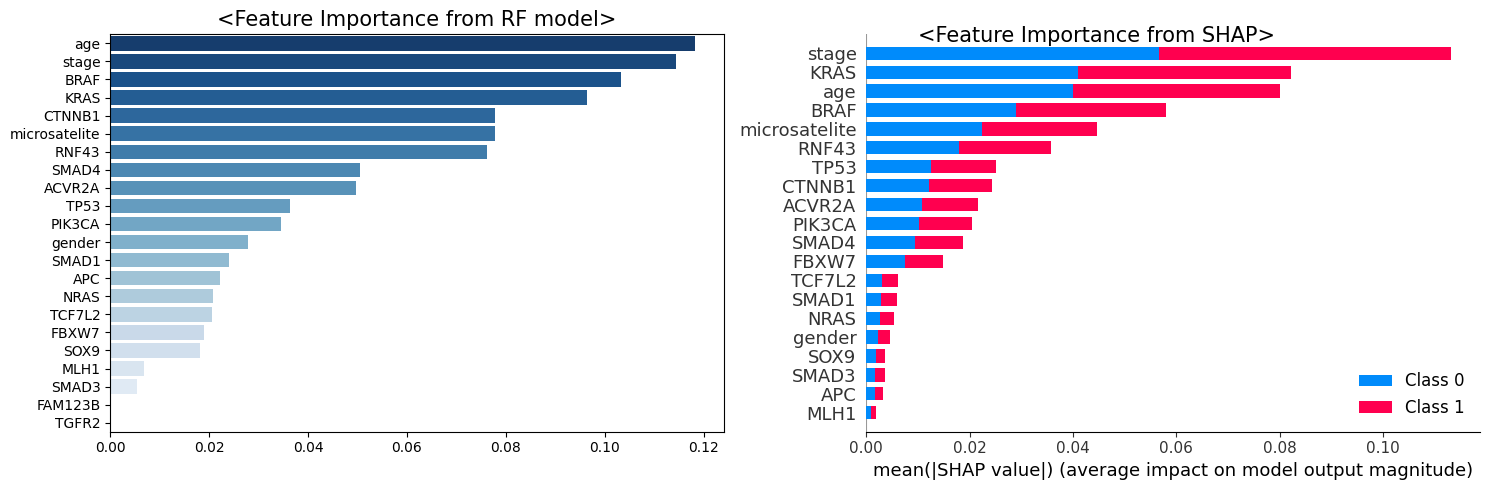

In [285]:
from_modeling_to_plotting_with_stratify(X, y2)

> p38i

f1_score (정밀도 & 재현율 조화 평균값) -->  0.7222


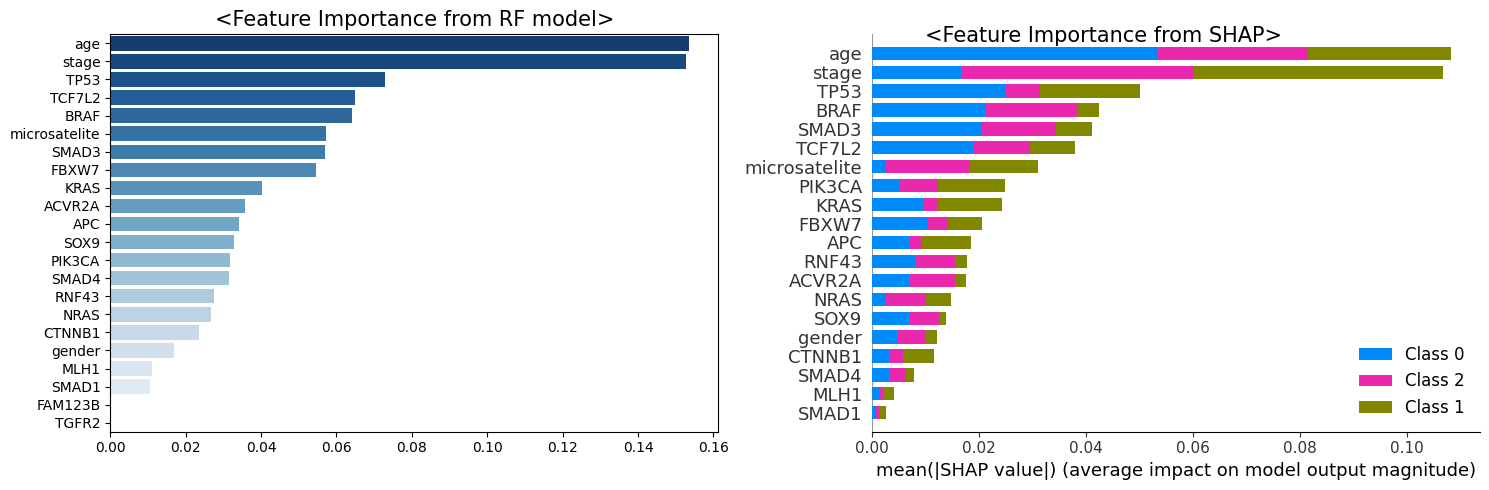

In [286]:
from_modeling_to_plotting_with_stratify(X, y3)

> Noggin

f1_score (정밀도 & 재현율 조화 평균값) -->  0.6975
roc_auc_score (모델 예측의 정확도) -->  0.75


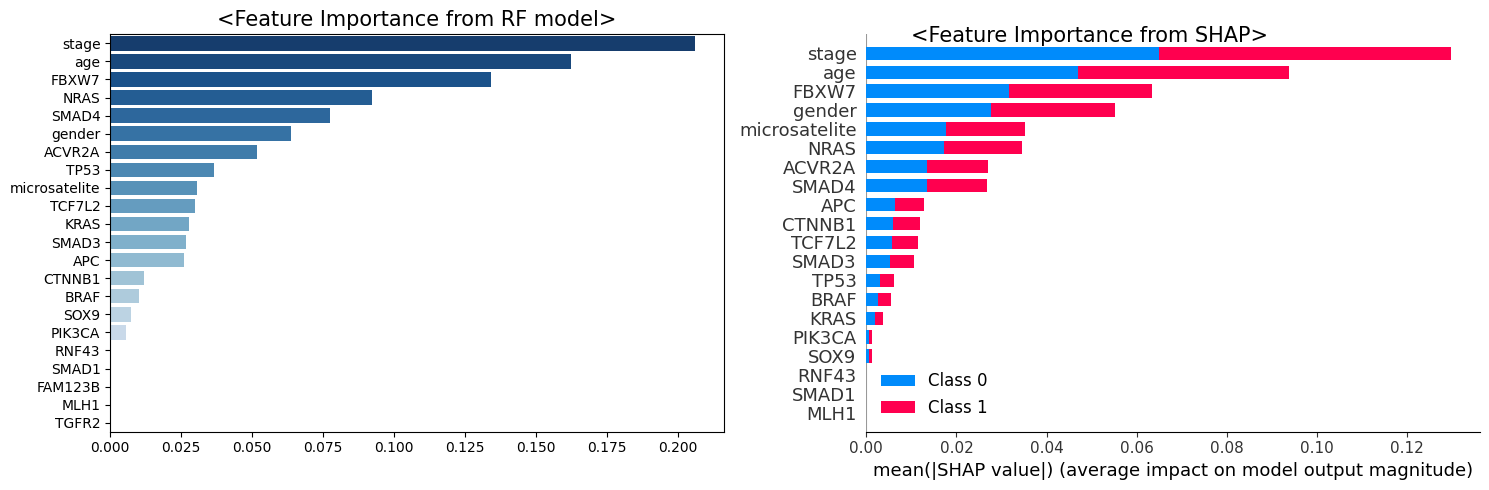

In [287]:
from_modeling_to_plotting_with_stratify(X, y4)

> TFGbi

f1_score (정밀도 & 재현율 조화 평균값) -->  0.5556
roc_auc_score (모델 예측의 정확도) -->  0.7407


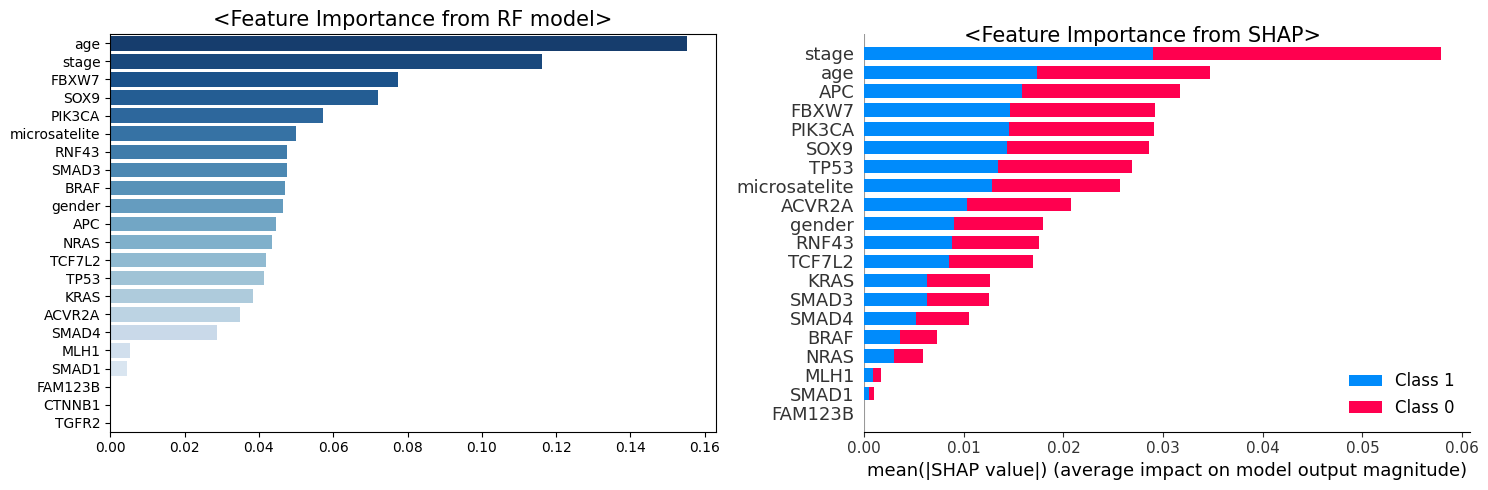

In [288]:
from_modeling_to_plotting_with_stratify(X, y5)

> Normoxia

f1_score (정밀도 & 재현율 조화 평균값) -->  0.2857


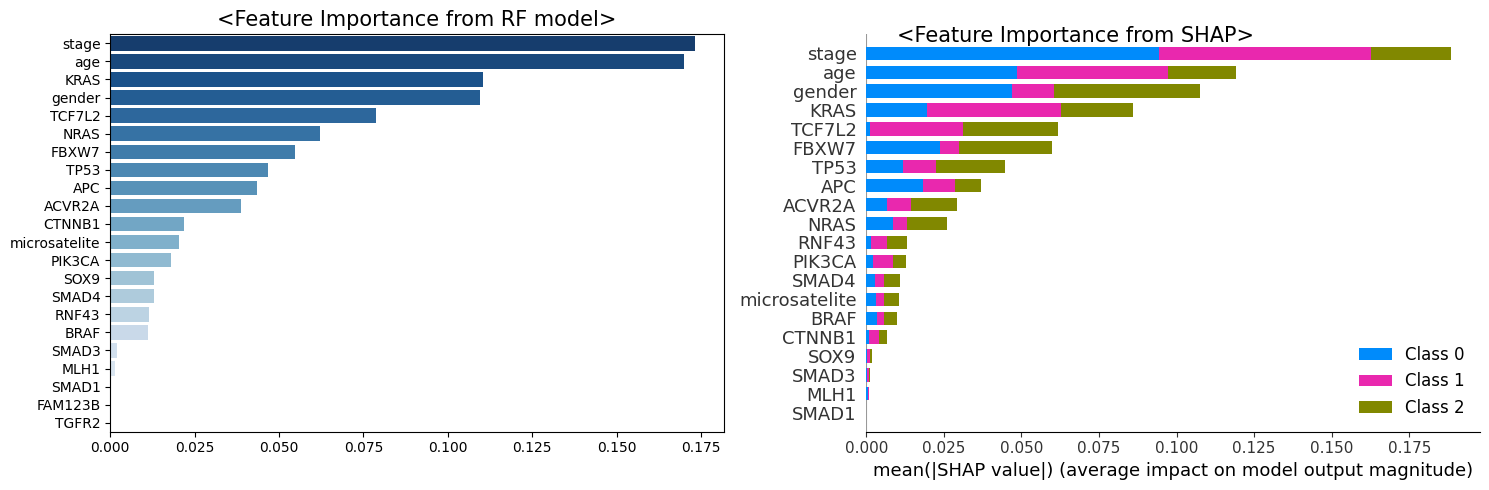

In [289]:
from_modeling_to_plotting_with_stratify(X, y6)

# Model explanation through Decision Tree

> Function

In [126]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# from modeling decision tree to plotting tree
def from_modeling_to_dt_plot(X,y):
    x_train, x_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=.2, # test_size --> .2? try different ratio
                                                        stratify=y,
                                                        random_state=5)
    dt_clf = DecisionTreeClassifier(max_depth=4,
                                   criterion='gini',
                                    random_state=5,
                                    class_weight='balanced'
                                    )
    dt_clf.fit(x_train, y_train)
    print(dt_clf.feature_importances_)

    # tree plot
    tree.plot_tree(dt_clf, filled=True, feature_names=X.columns,
                   class_names=['0', '1'])
    plt.rcParams['figure.figsize'] = [40,10]


> TGFbi

In [106]:
X.columns

Index(['APC', 'CTNNB1', 'TCF7L2', 'FAM123B', 'SOX9', 'RNF43', 'KRAS', 'NRAS',
       'BRAF', 'PIK3CA', 'TGFR2', 'ACVR2A', 'SMAD1', 'SMAD3', 'SMAD4', 'TP53',
       'FBXW7', 'MLH1', 'gender', 'age', 'microsatelite', 'stage'],
      dtype='object')

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 8.46644117e-01
 1.53355883e-01 1.16343834e-16]


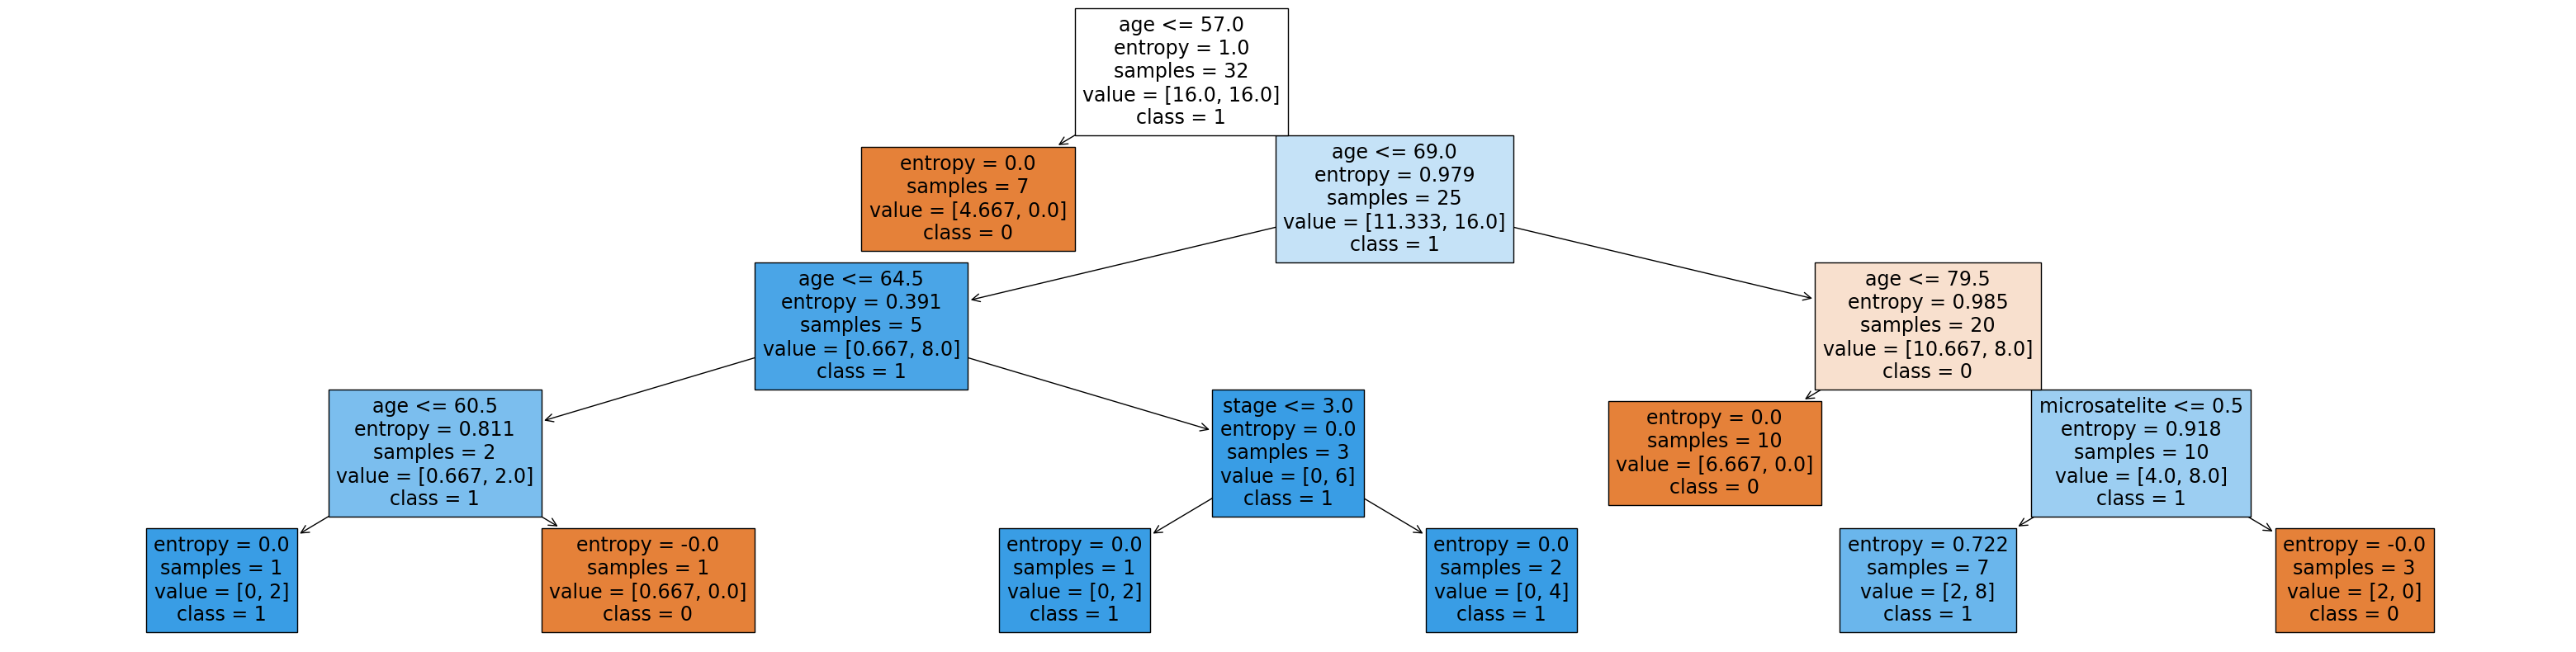

In [115]:
from_modeling_to_dt_plot(X, y5)

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 8.33333333e-01 1.66666667e-01 2.60208521e-16]


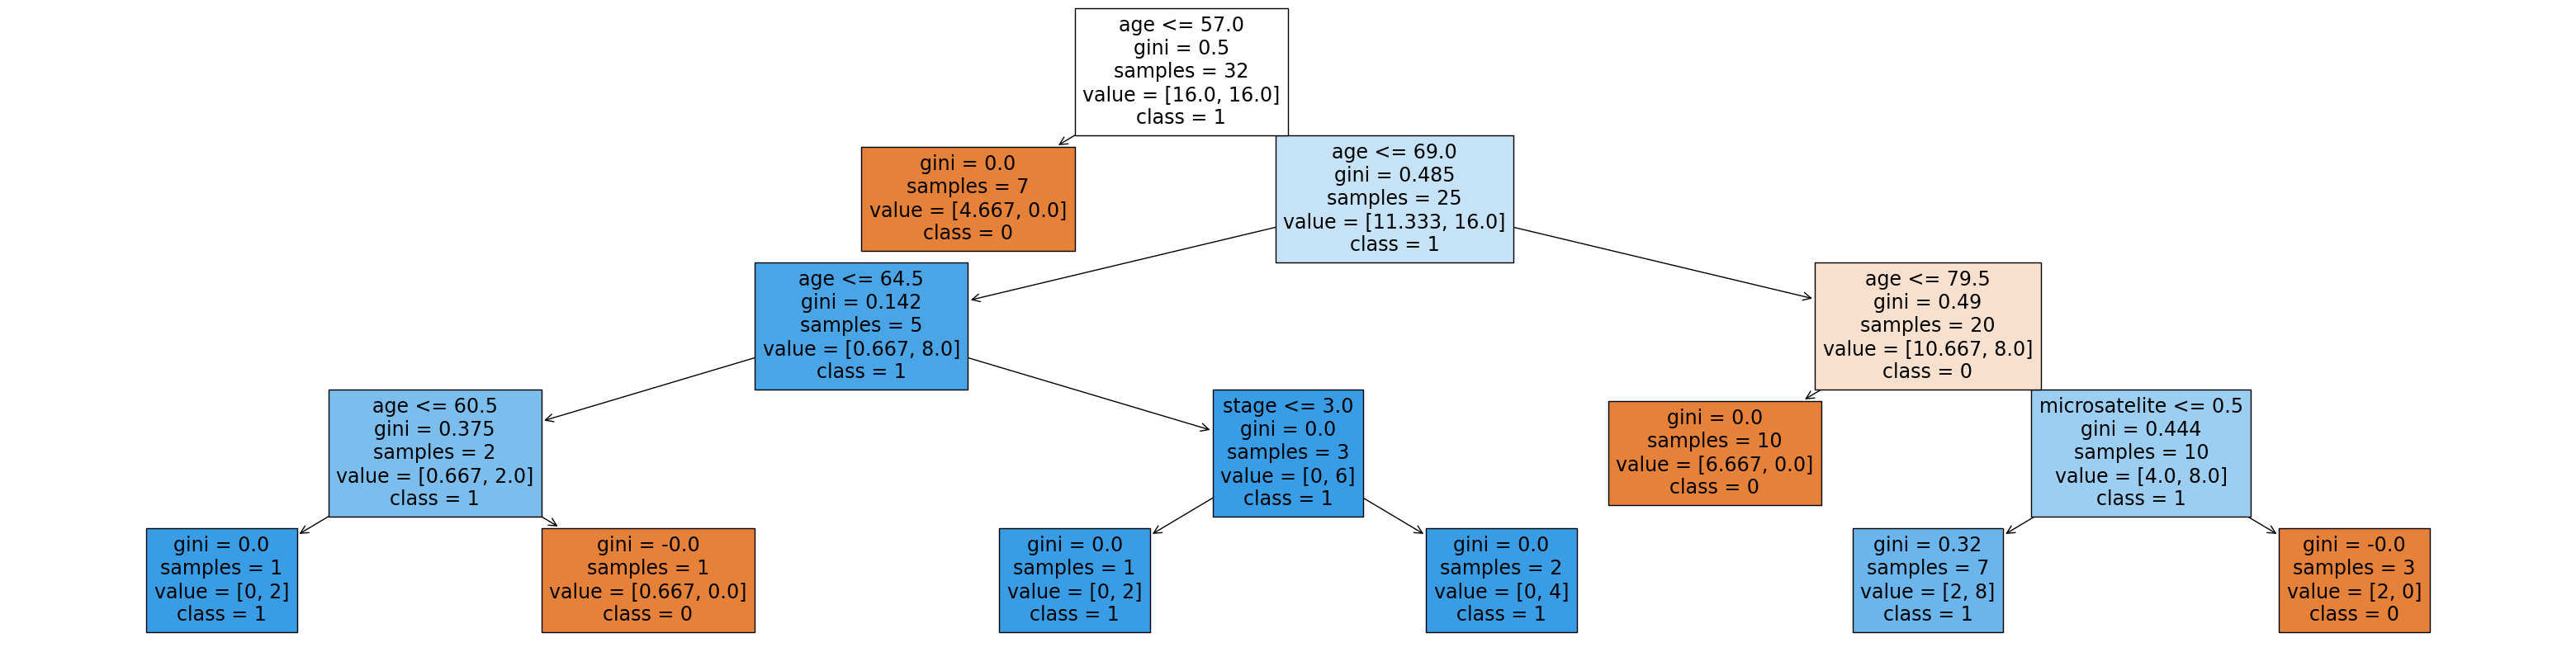

In [127]:
# with less # of variables
# independent variables
tgfbi_cols = ['APC', 'SOX9', 'RNF43', 'KRAS',
              'ACVR2A', 'SMAD4', 'TP53', 'FBXW7',
              'gender', 'age', 'microsatelite', 'stage']
X = new_df[tgfbi_cols]
from_modeling_to_dt_plot(X,y5)

# Model Explanation through Logistic Regression

> TGFbi

roc_auc (test) :  0.25
roc_auc (train) :  0.4322916666666667
f1_score (test) :  0.42857142857142855
f1_score (train) :  0.42857142857142855


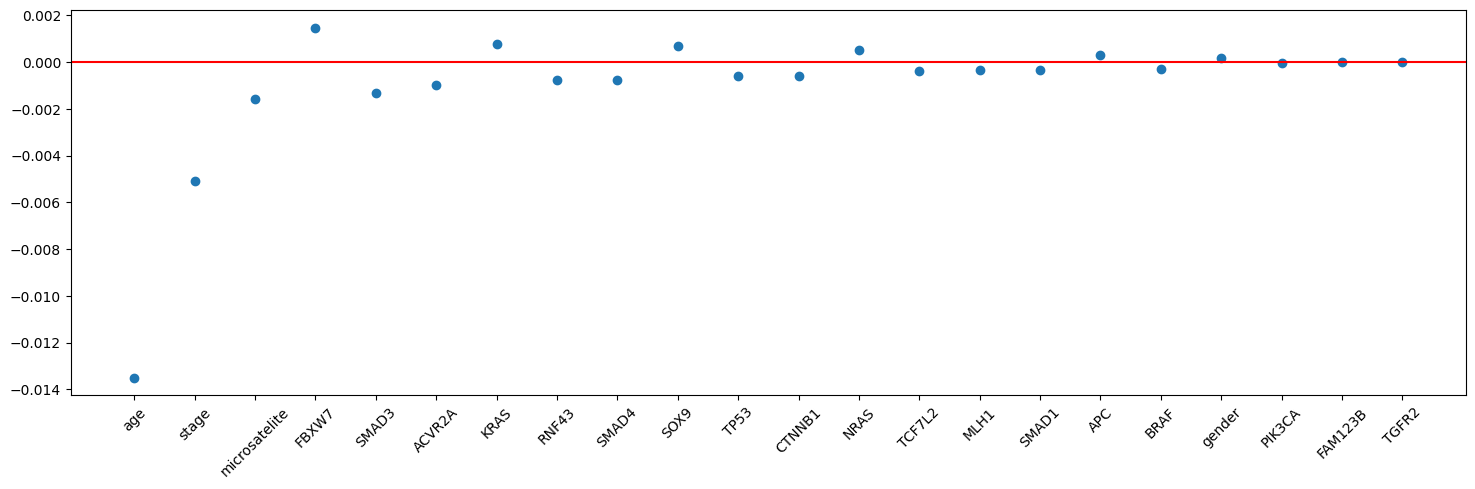

In [263]:
# train_test_split
# del lr_clf
x_train, x_test, y_train, y_test = train_test_split(X, y5,
                                                    test_size=.2, # test_size --> .2? try different ratio
                                                    stratify=y5,
                                                    random_state=5)

# over-sampling
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=5, k_neighbors=1) # SMOTE
x_sm_sampling, y_sm_sampling = sm.fit_resample(x_train, y_train)

# 1. Modeling without over-sampling
# show f1_score and (or) roc_auc_score
lr_clf = LogisticRegressionCV(cv=5,
                     penalty='elasticnet',
                     solver='saga',
                     Cs=np.power(10, np.arange(-3,1,dtype=float)),
                     l1_ratios=np.linspace(0,1,num=6, dtype=float),
                     max_iter=100,
                     random_state=5)
lr_clf.fit(x_train, y_train)

# prediction
y_pred_test = lr_clf.predict(x_test)
y_pred_train = lr_clf.predict(x_train)
y_pred_proba_test = lr_clf.predict_proba(x_test)[:,1]
y_pred_proba_train = lr_clf.predict_proba(x_train)[:,1]

f1_score_test = f1_score(y_test, y_pred_test, average='macro')
f1_score_train = f1_score(y_train, y_pred_train, average='macro')
roc_auc_score_test = roc_auc_score(y_test, y_pred_proba_test)
roc_auc_score_train = roc_auc_score(y_train, y_pred_proba_train)
print('roc_auc (test) : ', roc_auc_score_test)
print('roc_auc (train) : ', roc_auc_score_train)
print('f1_score (test) : ', f1_score_test)
print('f1_score (train) : ', f1_score_train)

coef_df = pd.DataFrame(columns=lr_clf.feature_names_in_, data=lr_clf.coef_).T
coef_df.columns = ['coeffcients']
coef_df = pd.DataFrame(coef_df['coeffcients'].sort_values(key=lambda x: np.abs(x))[::-1])

# plotting
plt.figure(figsize=(18,5))
plt.scatter(y=coef_df['coeffcients'], x=coef_df.index)
plt.axhline(y = 0, color = 'r', linestyle = '-')
plt.xticks(rotation=45)
plt.show()

roc_auc (train): 0.7314814814814815, roc_auc (test): 0.875
f1_score (train): 0.625, f1_score (test): 0.5465587044534412
roc_auc (train): 0.4537037037037037, roc_auc (test): 0.35416666666666674
f1_score (train): 0.42857142857142855, f1_score (test): 0.42857142857142855


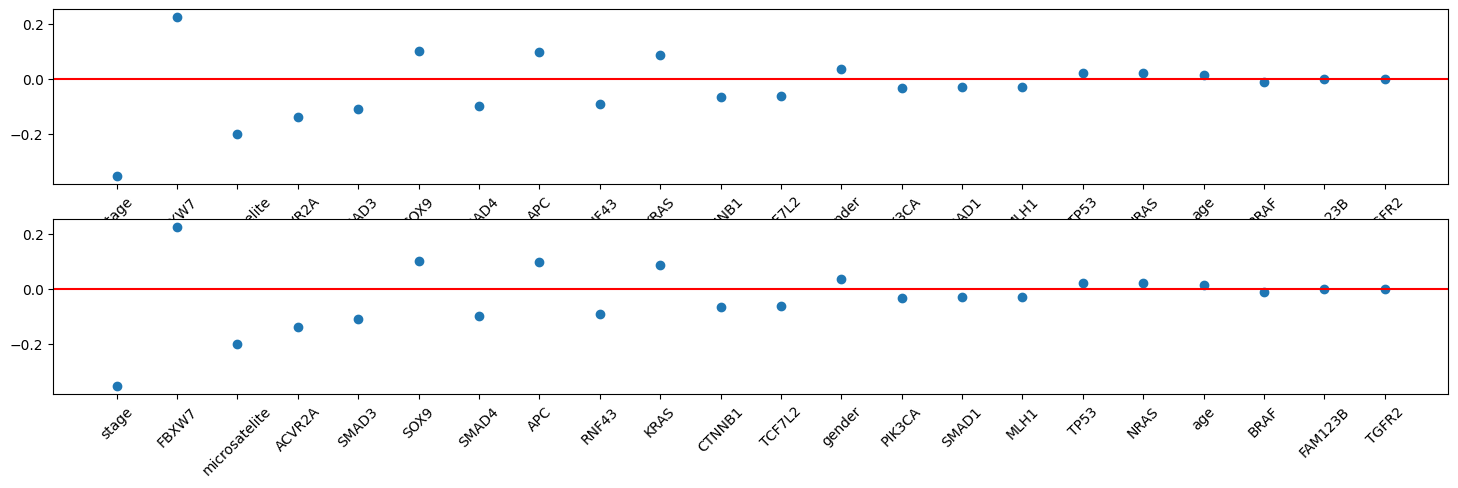

In [294]:
# 2. Modeling without over-sampling

def plot_coef_from_model(X, y):

    x_train, x_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=.4, # test_size --> .2? try different ratio
                                                    stratify=y,
                                                    random_state=5)

    # SMOTE (over-sampling)
    sm = SMOTE(random_state=5, k_neighbors=1)
    x_sm_sampling, y_sm_sampling = sm.fit_resample(x_train, y_train)

    lr_clf = LogisticRegressionCV(cv=5,
                        penalty='elasticnet',
                        solver='saga',
                        Cs=np.power(10, np.arange(-3,1,dtype=float)),
                        l1_ratios=np.linspace(0,1,num=6, dtype=float),
                        max_iter=100,
                        random_state=5)
    lr_clf.fit(x_sm_sampling, y_sm_sampling)

    # prediction
    y_pred_test = lr_clf.predict(x_test)
    y_pred_train = lr_clf.predict(x_train)
    y_pred_proba_test = lr_clf.predict_proba(x_test)[:,1]
    y_pred_proba_train = lr_clf.predict_proba(x_train)[:,1]

    f1_score_test = f1_score(y_test, y_pred_test, average='macro')
    f1_score_train = f1_score(y_train, y_pred_train, average='macro')
    roc_auc_score_test = roc_auc_score(y_test, y_pred_proba_test)
    roc_auc_score_train = roc_auc_score(y_train, y_pred_proba_train)
    print('roc_auc (train): {}, roc_auc (test): {}'.format(roc_auc_score_train, roc_auc_score_test))
    print('f1_score (train): {}, f1_score (test): {}'.format(f1_score_train, f1_score_test))

    coef_df_1 = pd.DataFrame(columns=lr_clf.feature_names_in_, data=lr_clf.coef_).T
    coef_df_1.columns = ['coeffcients']
    coef_df_1 = pd.DataFrame(coef_df['coeffcients'].sort_values(key=lambda x: np.abs(x))[::-1])

    # without over-sampling
    lr_clf = LogisticRegressionCV(cv=5,
                        penalty='elasticnet',
                        solver='saga',
                        Cs=np.power(10, np.arange(-3,1,dtype=float)),
                        l1_ratios=np.linspace(0,1,num=6, dtype=float),
                        max_iter=100,
                        random_state=5)
    lr_clf.fit(x_train, y_train)

    # prediction
    y_pred_test = lr_clf.predict(x_test)
    y_pred_train = lr_clf.predict(x_train)
    y_pred_proba_test = lr_clf.predict_proba(x_test)[:,1]
    y_pred_proba_train = lr_clf.predict_proba(x_train)[:,1]

    f1_score_test = f1_score(y_test, y_pred_test, average='macro')
    f1_score_train = f1_score(y_train, y_pred_train, average='macro')
    roc_auc_score_test = roc_auc_score(y_test, y_pred_proba_test)
    roc_auc_score_train = roc_auc_score(y_train, y_pred_proba_train)
    print('roc_auc (train): {}, roc_auc (test): {}'.format(roc_auc_score_train, roc_auc_score_test))
    print('f1_score (train): {}, f1_score (test): {}'.format(f1_score_train, f1_score_test))

    coef_df_2 = pd.DataFrame(columns=lr_clf.feature_names_in_, data=lr_clf.coef_).T
    coef_df_2.columns = ['coeffcients']
    coef_df_2 = pd.DataFrame(coef_df['coeffcients'].sort_values(key=lambda x: np.abs(x))[::-1])

    # merge dataframes
    merged_df = pd.merge(coef_df_1, coef_df_2, left_index=True, right_index=True)
    merged_df.columns = ['with_sampling', 'without_sampling']

    # plotting
    plt.figure(figsize=(18,5))
    plt.subplot(2,1,1)
    plt.scatter(y=merged_df['with_sampling'], x=merged_df.index)
    plt.axhline(y = 0, color = 'r', linestyle = '-')
    plt.xticks(rotation=45)

    plt.subplot(2,1,2)
    plt.scatter(y=merged_df['without_sampling'], x=merged_df.index)
    plt.axhline(y = 0, color = 'r', linestyle = '-')
    plt.xticks(rotation=45)

    plt.show()

    return

plot_coef_from_model(X, y5)


    Version 02 ends here